In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import scipy as sp
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv(r"data\car data.csv")
df

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [5]:
df.duplicated().sum() # There are duplicates in the datset. 

2

In [6]:
df.drop_duplicates(inplace=True) # We have dropped the duplicates. 

In [7]:
df.shape # Self explanatory. 

(299, 9)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,299.0,2013.615385,2.896868,2003.00,2012.00,2014.00,2016.00,2018.0
Selling_Price,299.0,4.589632,4.984240,0.10,0.85,3.51,6.00,35.0
Present_Price,299.0,7.541037,8.566332,0.32,1.20,6.10,9.84,92.6
Driven_kms,299.0,36916.752508,39015.170352,500.00,15000.00,32000.00,48883.50,500000.0
Owner,299.0,0.043478,0.248720,0.00,0.00,0.00,0.00,3.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       299 non-null    object 
 1   Year           299 non-null    int64  
 2   Selling_Price  299 non-null    float64
 3   Present_Price  299 non-null    float64
 4   Driven_kms     299 non-null    int64  
 5   Fuel_Type      299 non-null    object 
 6   Selling_type   299 non-null    object 
 7   Transmission   299 non-null    object 
 8   Owner          299 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 23.4+ KB


# EDA

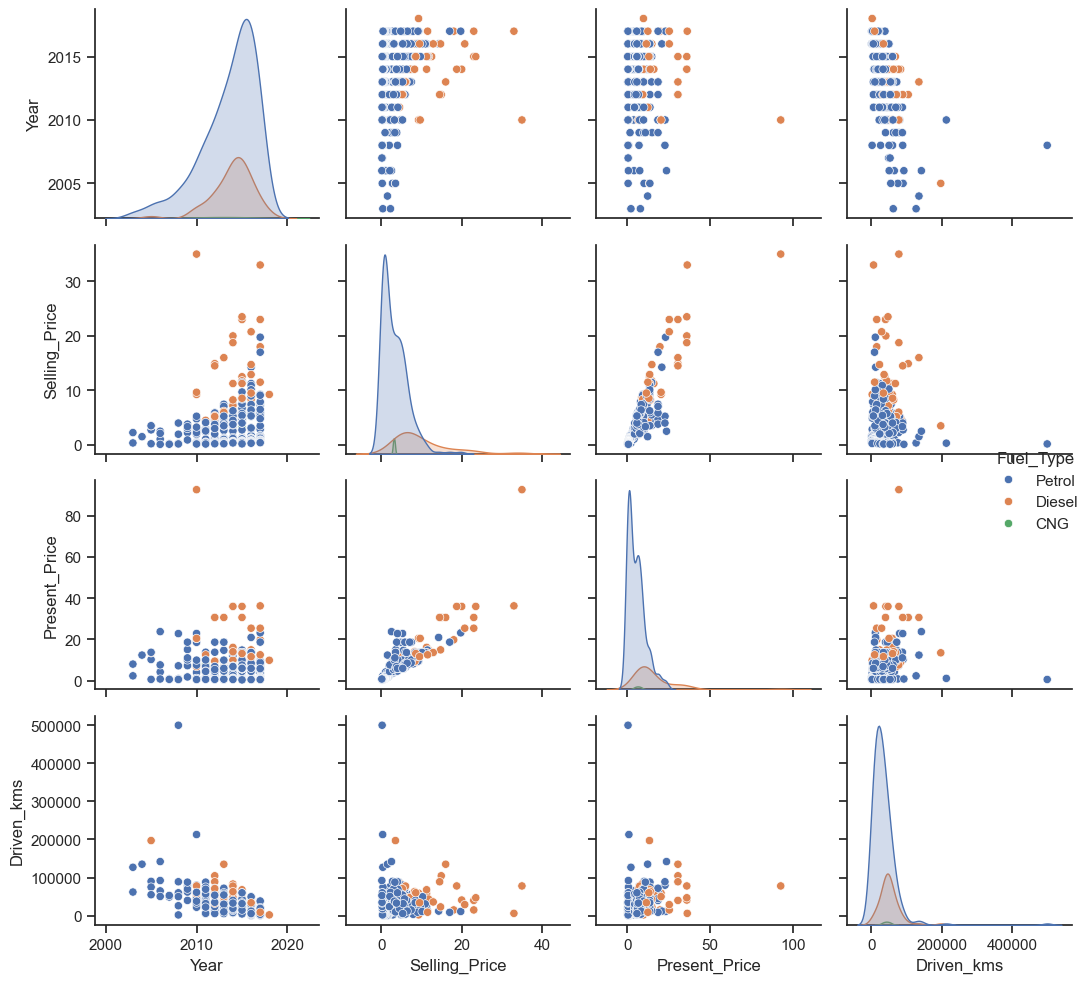

In [249]:
sns.pairplot(df, vars=["Year", "Selling_Price", "Present_Price", "Driven_kms"], hue="Fuel_Type")
plt.tight_layout()
plt.show()

# Some of the pair plots have some linear relationship. Nothing strong as such.

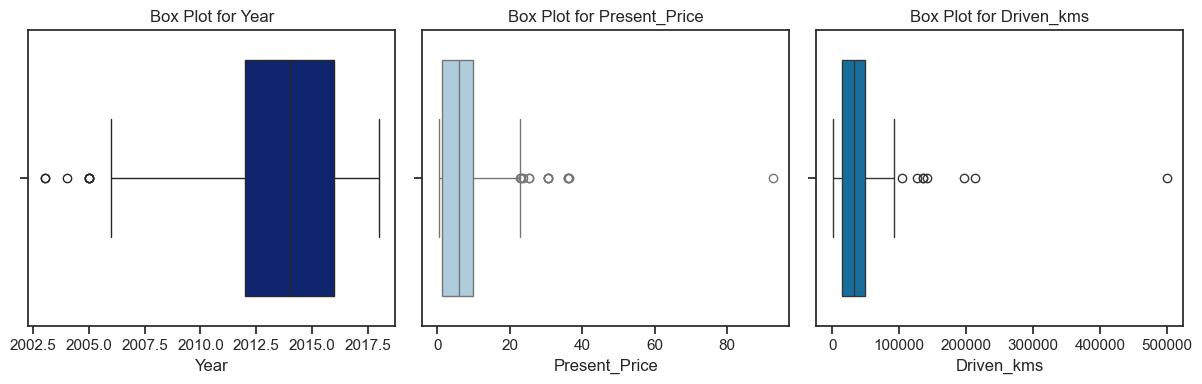

In [250]:
sns.set(style='ticks')
fig, axes = plt.subplots(1, 3, figsize=(12,4))
numeric_cols = ['Year','Present_Price','Driven_kms']

color_palettes = ["dark", "Paired", "colorblind"]

for i, j in enumerate(numeric_cols):
    color_palette = sns.color_palette(palette=color_palettes[i])
    sns.boxplot(x=df[j], ax=axes[i],palette=color_palette)
    axes[i].set_title(f'Box Plot for {j}')

plt.tight_layout()
plt.show()

# There are some outliers. We shall be keeping it as the dataset is very small & it would make no sense to remove as removal can cause some data loss.  

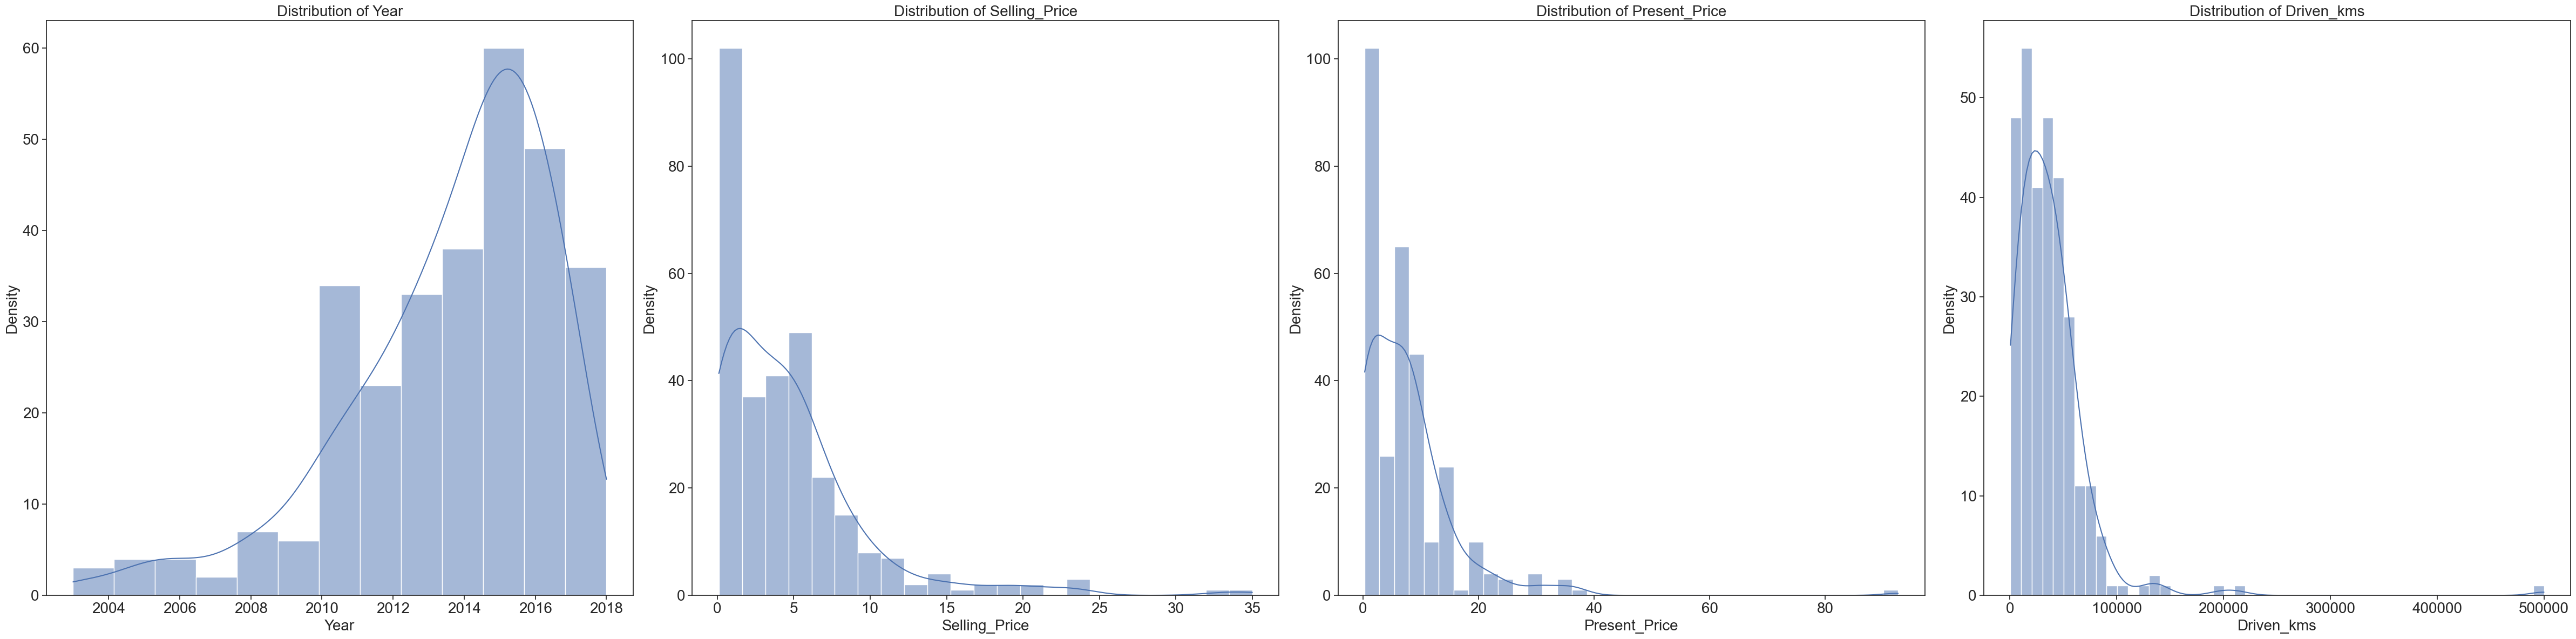

In [251]:
nrows = 1
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*12, nrows*12))

for i, j in enumerate(df.select_dtypes(include=['int64', 'float64']).columns):
    if j!='Owner':
        row = i // ncols
        col_idx = i % ncols
        sns.histplot(x=df[j],kde=True, ax=axes[col_idx])
        axes[col_idx].set_xlabel(j, fontsize=20)
        axes[col_idx].set_ylabel('Density', fontsize=20)
        axes[col_idx].tick_params(axis='both', labelsize=20)
        axes[col_idx].set_title(f'Distribution of {j}', fontsize=20)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.show()

# All the graphs are pretty much skewed. 

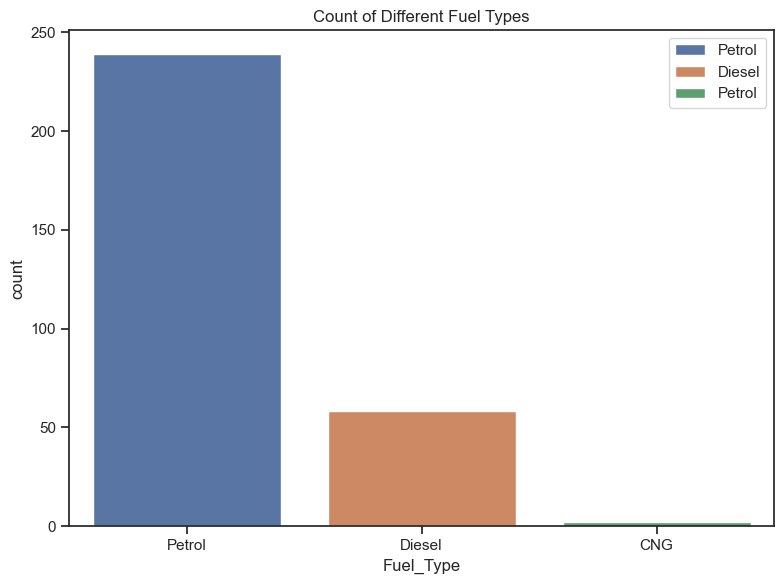

In [252]:
plt.figure(figsize=(8, 6))
sns.countplot(x="Fuel_Type", data=df, hue =df['Fuel_Type'])
plt.title("Count of Different Fuel Types")
plt.legend(df['Fuel_Type'])
plt.tight_layout()
plt.show()

# Most of the vehicles are petrol engine. 

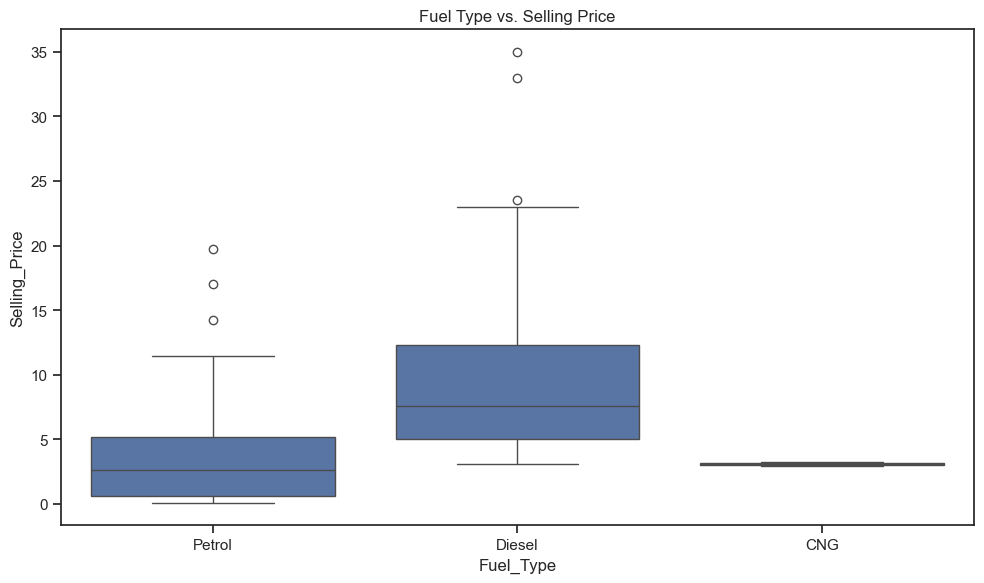

In [253]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Fuel_Type", y="Selling_Price", data=df)
plt.title("Fuel Type vs. Selling Price")
plt.tight_layout()
plt.show()

# Diesel cars have much higher selling price in general than petrol or CNG. This could be due to less data on Disesel cars from previous plot. 
# There is very data less to comment further on CNG.

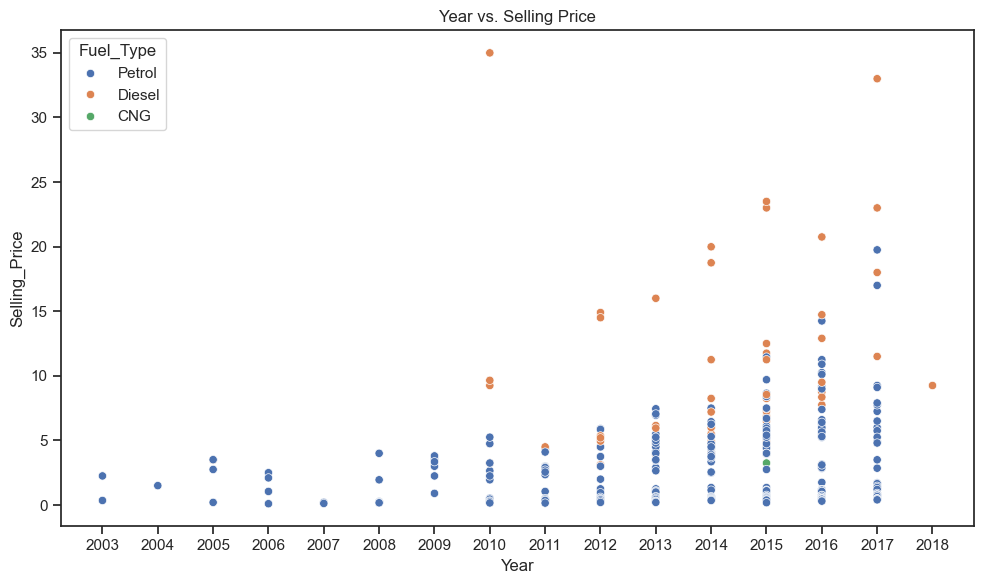

In [254]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Year", y="Selling_Price", data=df, hue=df['Fuel_Type'])
plt.title("Year vs. Selling Price")
plt.xticks(range(2003, 2019))
plt.tight_layout()
plt.show()

# The selling price of old vehicles are not very high. The outliers from 2010 & 2017 in particular are having very high selling price. 
# But the vehicle from 2018 is not having very goood price.This also reinforces the fact that old vehicle have less selling price. 

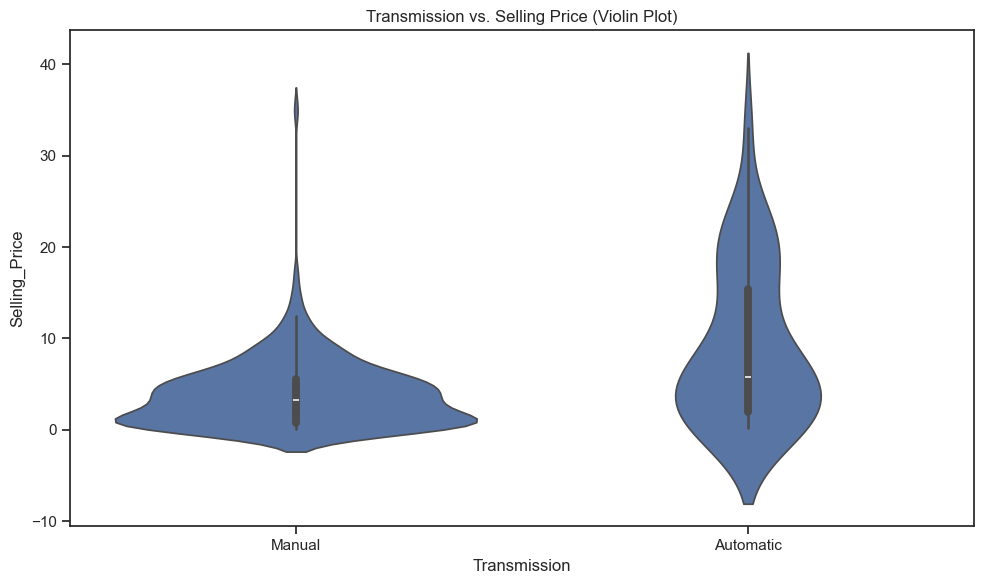

In [255]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Transmission", y="Selling_Price", data=df)
plt.title("Transmission vs. Selling Price (Violin Plot)")
plt.tight_layout()
plt.show()

# The violin plot for manual is having very wide distribution of selling price and then a long tail due to the outliers we have come across from previous plots. 
# While the plot for automatic is clustered within a specifc price range.  

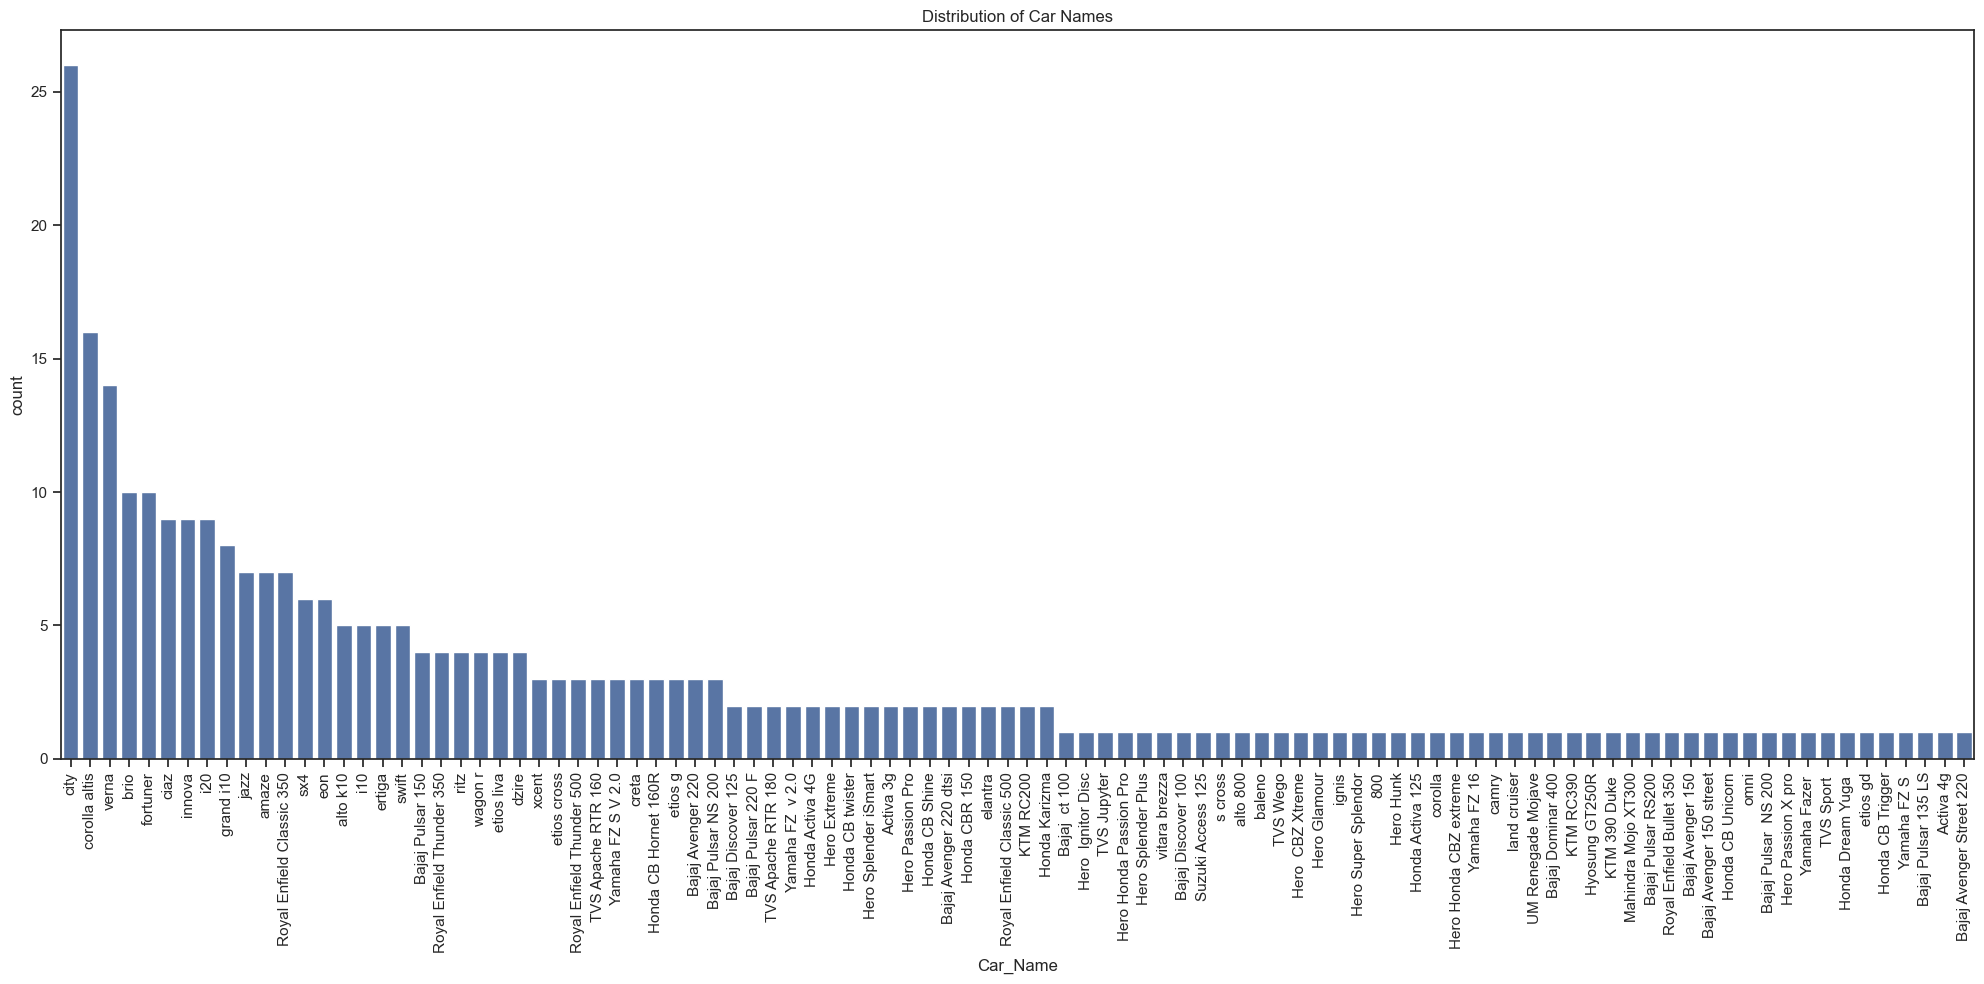

In [256]:
plt.figure(figsize=(20, 10))
sns.countplot(x="Car_Name", data=df, order=df['Car_Name'].value_counts().index)
plt.title("Distribution of Car Names")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Honda city tops the chart with the most count of selling cars followed by toyota corolla altis and Hyundai verna. 

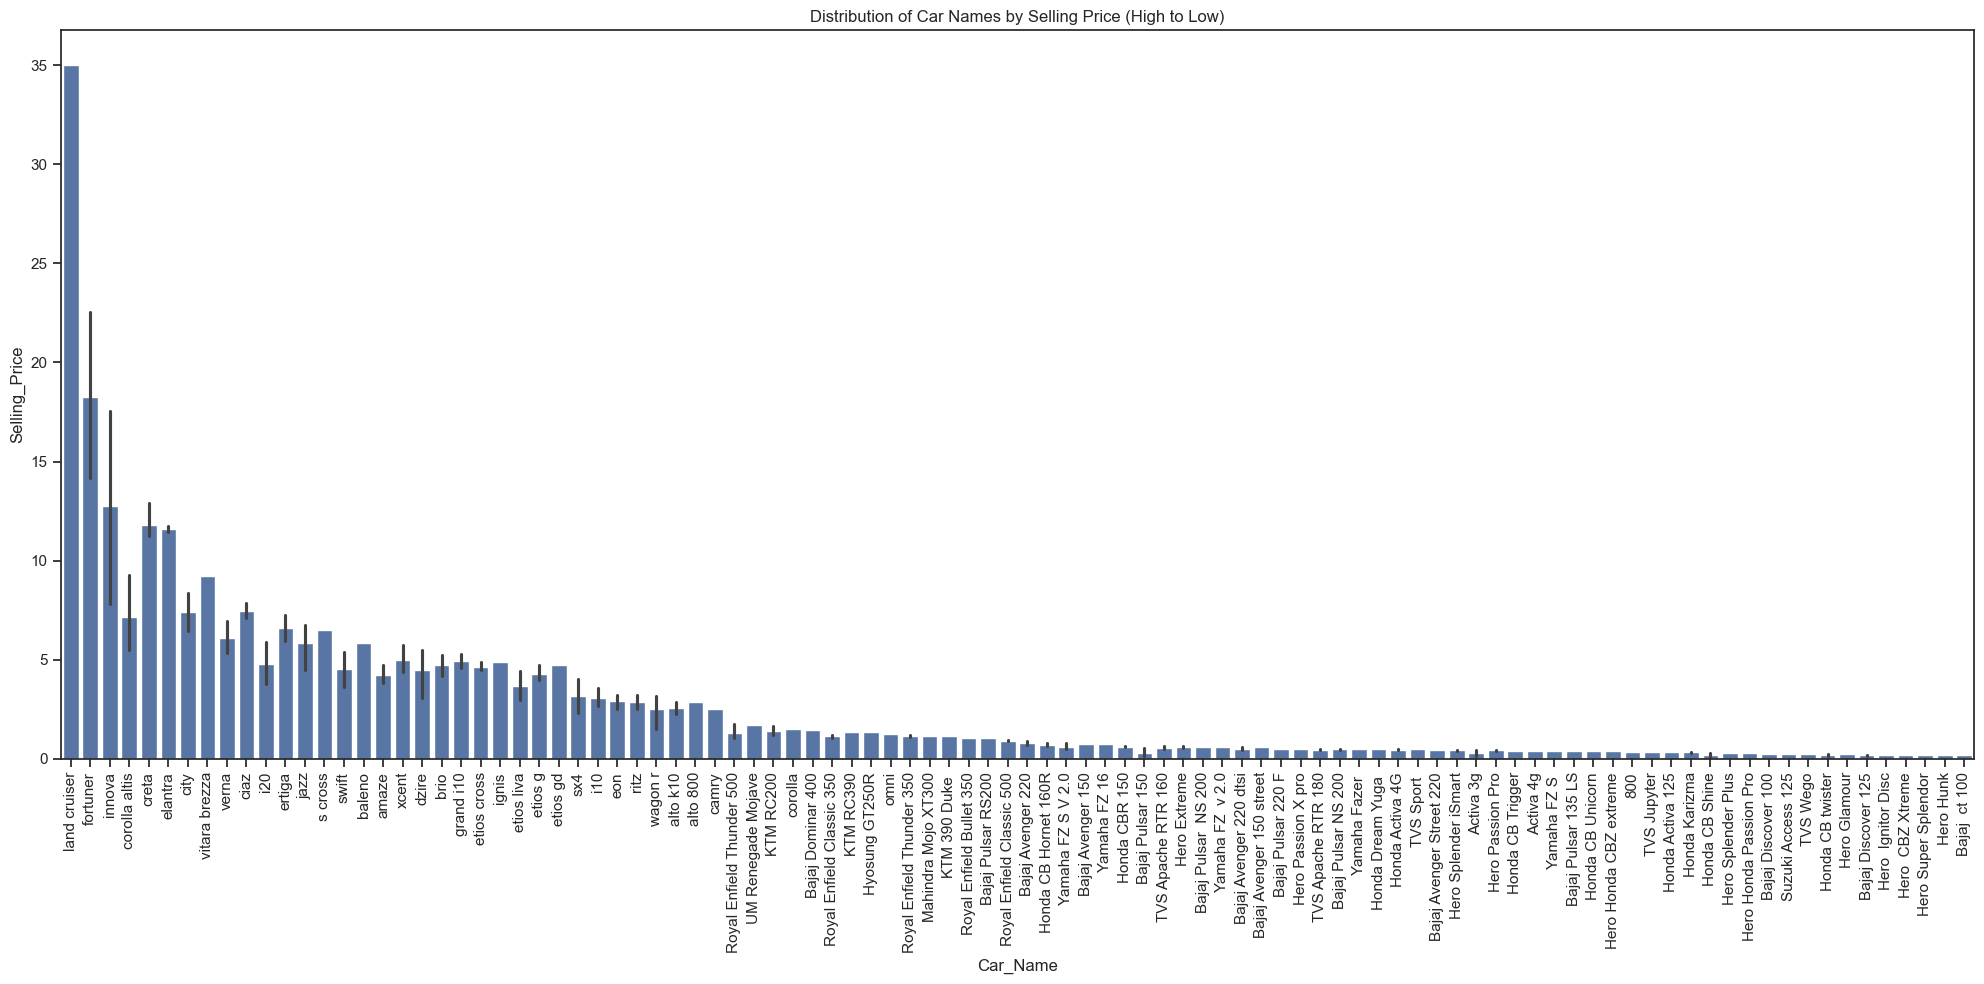

In [257]:
plt.figure(figsize=(20, 10))
df_sorted = df.sort_values(by='Selling_Price', ascending=False)
sns.barplot(x="Car_Name", y="Selling_Price", data=df_sorted)
plt.title("Distribution of Car Names by Selling Price (High to Low)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Top 4 cars with high selling price is from toyota followed by Hyundai creta. However, on a closer look from above count plot there is exactly one land cruiser 
# Therefore, not affected by average price unlike other cars. Same goes to fortuner & innova with data less than 10 cars.
# This alone can easily affect the distribution of the data.  

<Figure size 1000x600 with 0 Axes>

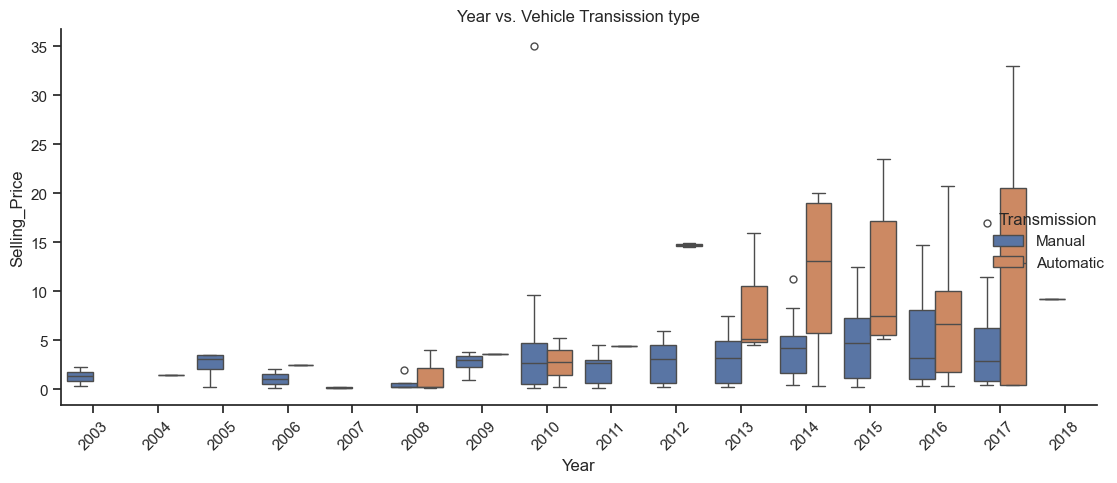

In [258]:
plt.figure(figsize=(10, 6))
sns.catplot(x="Year", y="Selling_Price", data=df, hue="Transmission", kind="box", height=5, aspect=2)
plt.title("Year vs. Vehicle Transission type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The count of manual vehicles are: 260
The count of automatic vehicles are: 39


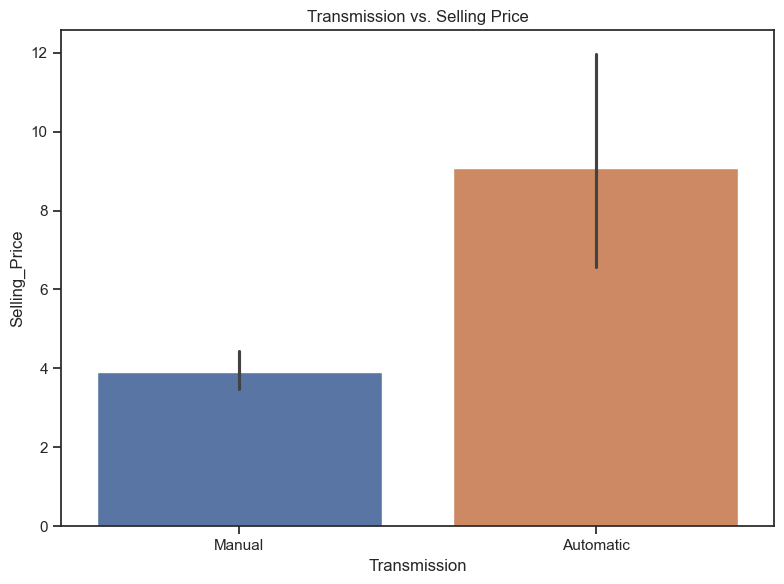

In [259]:
print("The count of manual vehicles are:",df['Transmission'].value_counts()[0])
print("The count of automatic vehicles are:",df['Transmission'].value_counts()[1])

plt.figure(figsize=(8, 6))
sns.barplot(x="Transmission", y="Selling_Price", data=df, hue=df['Transmission'])
plt.title("Transmission vs. Selling Price")
plt.tight_layout()
plt.show()

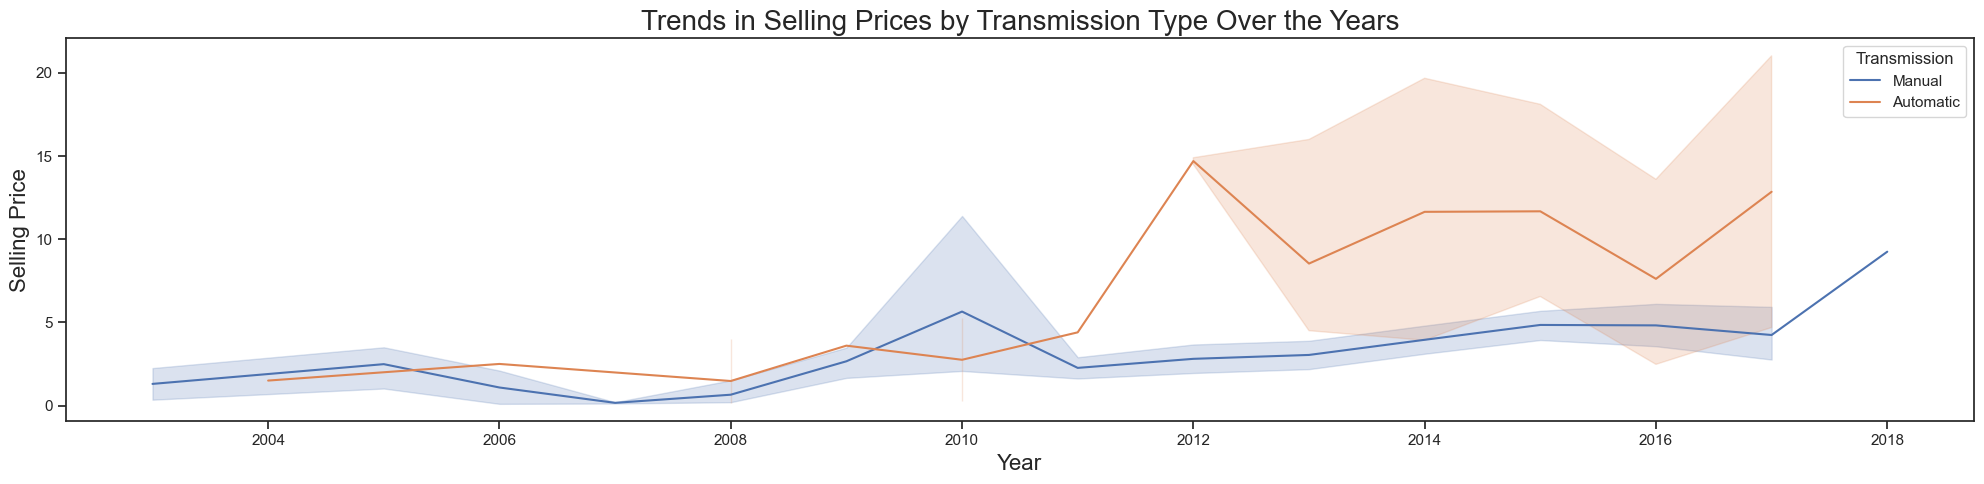

In [260]:
plt.figure(figsize=(20, 5))
sns.lineplot(x=df['Year'], y=df['Selling_Price'], hue=df['Transmission'])
plt.title("Trends in Selling Prices by Transmission Type Over the Years", fontsize=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Selling Price", fontsize=16)
plt.tight_layout()
plt.show()

The rise of automatic cars started from 2008 in India and India being a price sensitive market and being one of the country in the world that has historically adopted manual cars over automatic as automatix cars tend to be atleast INR 80,000 more expensive than their petrol variant. Automatic transmissions are more complex in their build and rely on a network of sensors and other sophisticated engineering to give you the right gear change at the right time, hence the high cost. This is could also mean high selling cost for modern technology in the used car market. Perhaps,This is the reason for automatic used cars having much higher price range. This is valid from the plots we have seen above "Year vs. Vehicle Transission type", "Transmission vs. Selling Price & "Trends in Selling Prices by Transmission Type Over the Years".

# Model Building

In [261]:
df = df.drop(columns =["Car_Name"])

In [262]:
numeric_features = ['Year', 'Present_Price', 'Driven_kms']
numeric_transformer = StandardScaler()

In [263]:
categorical_features = ['Fuel_Type', 'Selling_type', 'Transmission']
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore')

In [264]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_cols', numeric_transformer, numeric_features),
        ('cat_cols', categorical_transformer, categorical_features)
    ])

In [265]:
initial_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [266]:
X = df.drop(columns=["Selling_Price"])
y = df['Selling_Price']

In [267]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [268]:
X_train_scaled = initial_pipeline.fit_transform(X_train,y_train)
X_test_scaled = initial_pipeline.transform(X_test)

In [269]:
models = [
    ["Linear Regression", LinearRegression()],
    ["Random Forest Regressor", RandomForestRegressor(n_jobs=-1,random_state=42)],
    ["Gradient Boosting Regressor", GradientBoostingRegressor(random_state=42)],
    ["XGBoost Regressor", XGBRegressor(n_jobs=-1,random_state=42)]]

results = []

for name, model in models:
    model.fit(X_train_scaled, y_train)

    # Cross-Validated Mean R2 Score
    r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, scoring='r2')
    mean_r2 = r2_scores.mean()

    # Cross-Validated Mean Squared Error (MSE)
    mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, scoring='neg_mean_squared_error')
    mean_mse = mse_scores.mean()

    # Cross-Validated Mean Absolute Error (MAE)
    mae_scores = -cross_val_score(model, X_train_scaled, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, scoring='neg_mean_absolute_error')
    mean_mae = mae_scores.mean()

    # Test the model
    y_pred = model.predict(X_test_scaled)

    # Test R-squared (R²) score
    test_r2 = r2_score(y_test, y_pred)

    # Test Mean Squared Error (MSE)
    test_mse = mean_squared_error(y_test, y_pred)

    # Test Root Mean Absolute Error (MAE)
    test_mae = mean_absolute_error(y_test, y_pred)

    results.append([name, round(mean_r2.mean(), 2), round(mean_mse.mean(), 2), round(mean_mae.mean(), 2),
                    round(test_r2, 2), round(test_mse, 2), round(test_mae, 2)]) # type: ignore

In [270]:
results_df = pd.DataFrame(results, columns=["Model", "CV R2", "Mean MSE", "Mean MAE",
                                            "Test R2", "Test MSE", "Test MAE"]
                          
                        ).sort_values(by="Test R2", ascending=False)
results_df # Xbgoost is peforming well among the bunch but it's not giving us very good r2 score. so, let us try hyperparameter tuning using optuna. 

,Model,CV R2,Mean MSE,Mean MAE,Test R2,Test MSE,Test MAE
3,XGBoost Regressor,0.84,4.22,0.73,0.80,5.27,1.09
0,Linear Regression,0.87,3.15,1.11,0.77,5.94,1.41
2,Gradient Boosting Regressor,0.87,3.50,0.69,0.72,7.15,1.19
1,Random Forest Regressor,0.86,3.56,0.75,0.51,12.59,1.48


# Hyperparameter with `XGBoost Regressor`

In [271]:
def Hypterparameter_tuning(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0)}

    model = XGBRegressor(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    return r2

In [272]:
study = optuna.create_study(direction='maximize')
study.optimize(Hypterparameter_tuning, n_trials=10) # Increase no of trials as you wish. 

[I 2023-11-02 18:06:36,303] A new study created in memory with name: no-name-c3b3f4b1-d593-4326-a4cb-87a8dc37c3b6
[I 2023-11-02 18:06:36,434] Trial 0 finished with value: 0.6386855661277893 and parameters: {'n_estimators': 143, 'max_depth': 8, 'learning_rate': 0.05462414994826076, 'subsample': 0.560450022049925, 'colsample_bytree': 0.5982299796385788, 'min_child_weight': 10, 'lambda': 3.0009245691637885, 'alpha': 0.02401472931429912}. Best is trial 0 with value: 0.6386855661277893.
[I 2023-11-02 18:06:37,321] Trial 1 finished with value: 0.8065558826713948 and parameters: {'n_estimators': 969, 'max_depth': 9, 'learning_rate': 0.03733212547175014, 'subsample': 0.9934254485467195, 'colsample_bytree': 0.5761877579398428, 'min_child_weight': 9, 'lambda': 0.0024648574802720365, 'alpha': 0.00410709844452966}. Best is trial 1 with value: 0.8065558826713948.
[I 2023-11-02 18:06:37,638] Trial 2 finished with value: 0.8230665805268379 and parameters: {'n_estimators': 541, 'max_depth': 4, 'learni

In [273]:
best_params = study.best_params

In [274]:
best_params = {
    'n_estimators': 786,
    'max_depth': 3,
    'learning_rate': 0.055739208637784324,
    'subsample': 0.7563441283737317,
    'colsample_bytree': 0.6343152551882135,
    'min_child_weight': 3,
    'lambda': 0.08378662808828764,
    'alpha': 0.018293844833644084} 
# The paramters generated from hyperparameters is random. Therefore, i am storing it in a hardcode, rather than just a variable. 

In [275]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("XGBoostRegressor", XGBRegressor(n_estimators=786,max_depth=3,learning_rate=0.055739208637784324,subsample=0.7563441283737317,
                             colsample_bytree=0.6343152551882135,min_child_weight=3, reg_lambda=0.08378662808828764,alpha =0.018293844833644084))
])

In [276]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols', StandardScaler(),
                                                  ['Year', 'Present_Price',
                                                   'Driven_kms']),
                                                 ('cat_cols',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Fuel_Type', 'Selling_type',
                                                   'Transmission'])])),
                ('XGBoostRegressor',
                 XGBRegressor(alpha=0.018293844833644084, base_score=None,
                              booster=No...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.055739208637784324, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=786, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [277]:
y_pred = final_pipeline.predict(X_test)

In [278]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {round(mae, 2)}")
print(f"Mean Squared Error (MSE): {round(mse,2)}")
print(f"R-squared (R2): {round(r2,2)}")

Mean Absolute Error (MAE): 0.87
Mean Squared Error (MSE): 2.67
R-squared (R2): 0.9


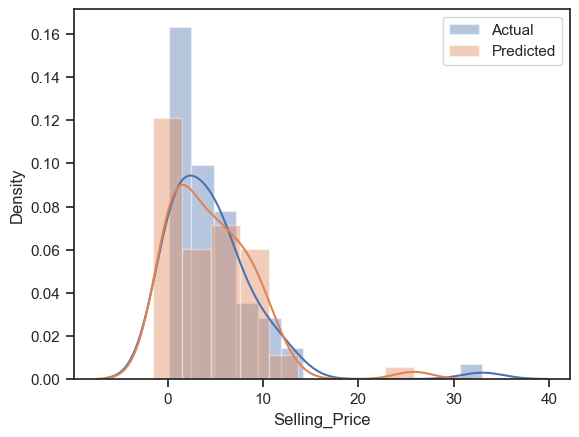

In [279]:
sns.distplot(y_test, label ='Actual')
sns.distplot(y_pred, label ='Predicted')
plt.legend()
plt.show() # The true prediction line is overlapping over the prediction line which is good though not very much. 

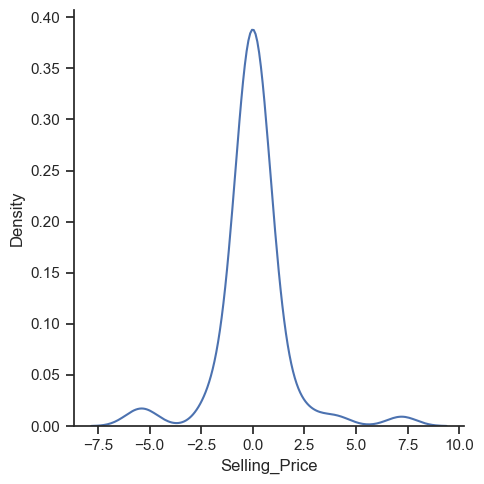

In [280]:
residual = y_test - y_pred
sns.displot(residual,kind='kde') 
plt.tight_layout()
plt.show() # The residuals form a Normal distribution plot

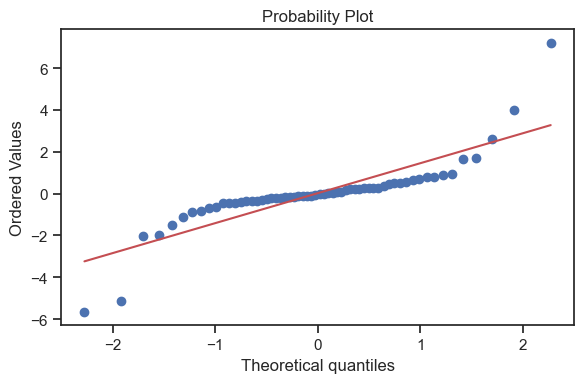

In [281]:
fig,ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual,plot=ax,fit=True)
plt.tight_layout()
plt.show() # Most of the data is very close to the line while some are away. Mostly these are the points affceted by the outliers in the dataset. 

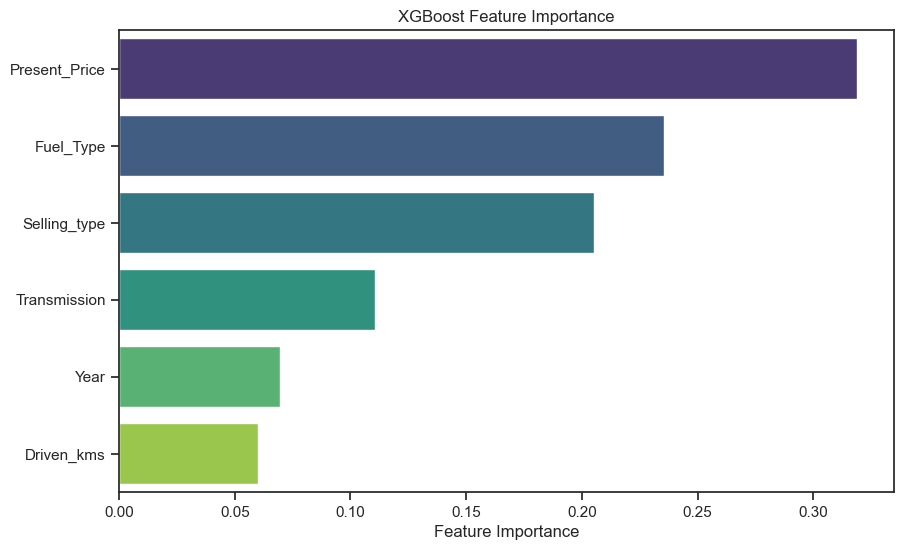

In [282]:
feature_importances = list(zip(X_train.columns, xgboost_model.feature_importances_))
feature_importances.sort(key=lambda x: x[1], reverse=True)
features, importances = zip(*feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

# Features contributing to the target ie Selling price in descending order.

In [283]:
# Save the model to a pickle file
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(final_pipeline, model_file)

## 📈 Conclusion

In this project, we aimed to build a machine learning model for predicting the selling price of used cars. We conducted extensive exploratory data analysis (EDA) to gain insights into the dataset and understand the relationships between various features and the selling price. We visualized the data and identified patterns such as the impact of the car's age, fuel type, transmission type, and brand on the selling price.

After preprocessing the data by encoding categorical variables and standardizing the numerical features, we trained and evaluated several machine learning models, including Linear Regression, Random Forest Regressor, Gradient Boosting Regressor, and XGBoost Regressor. Our model evaluation involved both cross-validation to assess model performance and testing on a holdout dataset. Among the models, the XGBoost Regressor achieved the highest R-squared (R²) score and performed well in predicting car selling prices.

We further conducted hyperparameter tuning for the XGBoost Regressor using Optuna to optimize model performance. The best-tuned model showed improved results, with lower Mean Absolute Error (MAE) and Mean Squared Error (MSE).

This project demonstrates the application of machine learning techniques in predicting car prices, which can be valuable for both sellers and buyers in the used car market. The model can help sellers estimate the fair market value of their cars, and buyers can use it to assess whether a listed price is reasonable.

Feel free to use this notebook as a reference for your own car price prediction projects or adapt it for different domains. Remember that model performance can be further improved with a larger dataset, more advanced feature engineering, and more extensive hyperparameter tuning.

Thank you for joining us on this journey through the world of used car selling price prediction!
